### Database of Shapes

The goal of this project is to create a dataset of various shapes and utilize it to train a Convolutional Neural Network (CNN). The process can be broken down into three main steps:

1. **Shape Generation**
   - The first step is to generate a dataset with a variety of different shapes. These shapes can include basic geometric figures such as squares, rectangles, circles, triangles, and polygons.
   - For each shape, we will vary parameters such as size, position, rotation to create diverse representations of each shape.

2. **Random Combination of Shapes**
   - To make the dataset more varied and complex, we will randomly combine these individual shapes. This could involve overlapping shapes, stacking them, or creating composite shapes. The randomness will introduce even more diversity, which will be useful for training the model to recognize complex patterns.
   
3. **Training a Model with Sparse Points**
   - After generating and combining shapes, we will implement a model that receives only a partial part of a shape and a list of sparse points that can be added sequentially to the shape. The model will be tasked with completing the shape based on these partial inputs.
   - With this approach, we can create a new dataset that includes partial shapes with missing points and labels, which can then be used to train a CNN capable of recognizing incomplete shapes and predicting the missing parts.

By following these steps, we can create a robust dataset and a model that learns to handle incomplete shape information, paving the way for applications like shape completion, segmentation, and recognition in computer vision.

## Import Libraries

To begin, we need to import several libraries that will aid in generating shapes, manipulating images, and training the model. Below is a list of essential libraries used for this project:


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
import os
from IPython.display import display
import pandas as pd

## 1.SHAPE GENERATION

In [2]:

# Define directory to save images
os.makedirs("Shape_dataset/Shape1", exist_ok=True)

In [3]:
# Define shape creation functions for outlined shapes
def create_square_outline(size, vertices ):
    img = Image.new("L", (size, size), "white")  # "L" mode for grayscale
    draw = ImageDraw.Draw(img)
    draw.polygon(vertices, outline="black", width=1)
    return img

def create_circle_outline(size, bbox , random_angle ):
    img = Image.new("L", (size, size), "white")
    draw = ImageDraw.Draw(img)
    draw.ellipse(bbox, outline="black", width=1)

    # Applica una rotazione all'immagine intera
    rotated_img = img.rotate(random_angle, expand=True, fillcolor="white")
    return rotated_img
    

def create_triangle_outline(size, vertices):
    img = Image.new("L", (size, size), "white")
    draw = ImageDraw.Draw(img)
    draw.polygon(vertices, outline="black", width=1)
    return img

Let's see the image for some random variables

In [4]:
# Function to generate random parameters for each shape
def generate_random_square(size):
    # Randomly generate the top-left and top-right points for the top side
    x1 = random.randint(0, size)
    y1 = random.randint(0, size // 2)  # Keep the top points on the upper half of the image
    x2 = random.randint(0, size)
    y2 = random.randint(0, size // 2)
    
    # Randomly generate the bottom-left and bottom-right points for the bottom side
    x3 = random.randint(0, size)
    y3 = random.randint(size // 2, size)  # Keep the bottom points on the lower half of the image
    x4 = random.randint(0, size)
    y4 = random.randint(size // 2, size)
    
    # Sort the points to ensure that the left and right sides are in the correct order
    top_left = (min(x1, x2), min(y1, y2))
    top_right = (max(x1, x2), min(y1, y2))
    bottom_left = (min(x3, x4), max(y3, y4))
    bottom_right = (max(x3, x4), max(y3, y4))
    
    # The four points defining the trapezoid
    trapezoid_points = [top_left, top_right, bottom_right, bottom_left]
    
    return trapezoid_points


def generate_random_circle(size):
    # Randomly choose a bounding box for the circle
    x1, y1 = random.randint(10, size - 50), random.randint(10, size - 50)
    x2, y2 = random.randint(x1 + 20, size - 10), random.randint(y1 + 20, size - 10)

    # Angolo di rotazione casuale tra 0 e 360 gradi
    rotation_angle = random.uniform(0, 360)
    return [x1, y1, x2, y2] , rotation_angle

def generate_random_triangle(size):
    # Randomly choose three points for the triangle
    x1, y1 = random.randint(10, size - 50), random.randint(10, size - 50)
    x2, y2 = random.randint(x1 + 20, size - 10), random.randint(y1 + 20, size - 10)
    x3, y3 = random.randint(10, size - 50), random.randint(10, size - 50)
    return [(x1, y1), (x2, y2), (x3, y3)]


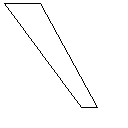

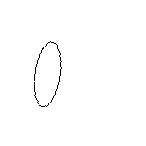

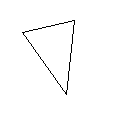

In [5]:
# Generate random images for each shape
size = 128

# Random parameters for the square (rectangle)
square_vertices = generate_random_square(size)
square_img = create_square_outline(size, square_vertices)

# Random parameters for the circle
circle_bbox, random_angle = generate_random_circle(size)
circle_img = create_circle_outline(size, circle_bbox , random_angle)

# Random parameters for the triangle
triangle_vertices = generate_random_triangle(size)
triangle_img = create_triangle_outline(size, triangle_vertices)

# Display all three images in the notebook
display(square_img)
display(circle_img)
display(triangle_img)

In [6]:
# Function to generate images and save them
def generate_images(num_images: int, size: int = 128, output_folder: str = "generated_shapes"):
    # Create a folder to save images if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

    # Generate the specified number of images
    for i in range(num_images):
        shape_type = random.choice(["trapezoid", "circle"])  # Randomly choose shape type
        
        if shape_type == "trapezoid":
            img = create_square_outline(size, vertices = generate_random_square(size))
        else:
            bbox, random_angle = generate_random_circle(size)
            img = create_circle_outline(size, bbox, random_angle)
        
        # Save the image
        # Generate random filename
        filename = f"image_{i+1}.png"
        # Set the full path where the image will be saved
        file_path = os.path.join(output_folder, filename)

        img.save(file_path)

    print(f"{num_images} images generated and saved to {output_folder}")

# Set the number of images to generate
num_images = 100  # You can change this number as needed
size = 128
output_folder = "Shape_dataset/Shape1"
# Generate and save images
generate_images(num_images, size, output_folder)

100 images generated and saved to Shape_dataset/Shape1


## 3. GET PARTIAL INFORMATION

In [7]:
def trace_ray(img, center_x, center_y, angle, max_distance=500):
    width, height = img.size
    x, y = center_x, center_y

    # Calcoliamo la direzione del raggio
    dx = np.cos(angle)
    dy = np.sin(angle)

    # Traccia il raggio e fermati se incontra un punto nero
    for _ in range(max_distance):
        x += dx
        y += dy

        int_x = int(x)
        int_y = int(y) 

        # Se il raggio esce fuori dai bordi dell'immagine, fermati
        if not (0 <= x < width and 0 <= y < height):
            end_x = x - dx
            end_y = y -dy
            break
        
        # Controlliamo il colore del pixel (0 significa nero, 255 significa bianco)
        pixel = img.getpixel((int_x, int_y))
        if pixel == 0:  # Trovato un punto nero, quindi fermiamo il raggio
            end_x , end_y = int_x, int_y
            break
        
        
        if (img.getpixel((int_x-1, int_y))==0 and img.getpixel((int_x, int_y-1))==0):
            end_x , end_y = int_x, int_y
            break

    return end_x, end_y

In [ ]:
def create_partial_view(shape_img, num_rays=8, visibility_fraction=0.5 , cam_x = None, cam_y = None):
    # Size of the image
    width, height = shape_img.size

    x_or_y = random.randint(0,1)
    # Choose a random "camera" point within the bounds
    if ( cam_x == None or cam_y== None):
        if x_or_y == 0:
            cam_x = random.randint(width // 4, 3 * width // 4)
            cam_y = random.randint(0,1) * size
        else :
            cam_y = random.randint(height // 4, 3 * height // 4)
            #so that camera is in the edge of the image
            cam_x = random.randint(0,1) * size

    # Create a mask to overlay on the shape image
    mask = Image.new("L", (width, height), "black")
    draw = ImageDraw.Draw(mask)

    # Define rays around the camera point
    angles = np.linspace(0, 2 * np.pi, num_rays, endpoint=False)
    for angle in angles[:int(num_rays * visibility_fraction)]:  # Limit rays by visibility fraction
        end_x, end_y = trace_ray(shape_img, cam_x, cam_y, angle)
        draw.line((cam_x, cam_y, end_x, end_y), fill="white", width=1)

    # Apply the mask to make only part of the shape visible
    partial_img = Image.composite(shape_img, Image.new("L", shape_img.size, "white"), mask)
    return partial_img, cam_x, cam_y ,mask

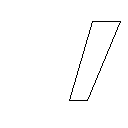

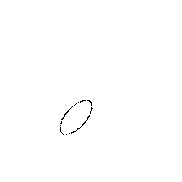

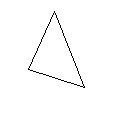

Your camera point is  60 0


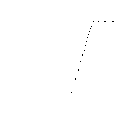

In [ ]:
# Generate random images for each shape
size = 128

# Random parameters for the square (rectangle)
square_vertices = generate_random_square(size)
square_img = create_square_outline(size, square_vertices)

# Random parameters for the circle
circle_bbox, random_angle = generate_random_circle(size)
circle_img = create_circle_outline(size, circle_bbox , random_angle)

# Random parameters for the triangle
triangle_vertices = generate_random_triangle(size)
triangle_img = create_triangle_outline(size, triangle_vertices)

# Display all three images in the notebook
display(square_img)
display(circle_img)
display(triangle_img)

square_partial_img, cam_x, cam_y, mask = create_partial_view(square_img, 100, visibility_fraction=1)
display(square_partial_img)
square_partial_img.show()

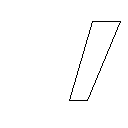

Your camera point is  128 37


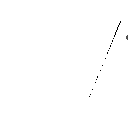

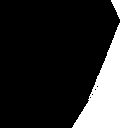

In [18]:
display(square_img)
square_partial_img, cam_x, cam_y, mask = create_partial_view(square_img, 2000, visibility_fraction=1, cam_x= cam_x, cam_y= cam_y)
draw = ImageDraw.Draw(square_partial_img)
draw.ellipse((cam_x - 2, cam_y - 2, cam_x + 2, cam_y + 2), fill="Red")  # Radius of 2 pixels
display(square_partial_img)
display(mask)
#square_partial_img.show()

Now we generate the dataset creating the images of the partial view. To get the sparse data we will just uniformly sample from the groundtruth minus the partial view

In [31]:
# Function to generate images and save them
def generate_partial_images(
        num_images: int,
        input_folder: str = "Shape1",
        output_img_folder: str = "Partial_Shape", 
        output_mask_folder:str = "Masked_Shape", 
        output_pos_folder : str = "Camera_Position"):
    # Create a folder to save images if it doesn't exist
    os.makedirs(output_img_folder, exist_ok=True)  # Create folder if it doesn't exist
    os.makedirs(output_mask_folder, exist_ok=True)  # Create folder if it doesn't exist
    os.makedirs(output_pos_folder, exist_ok=True)  # Create folder if it doesn't exist

    camera_pos_data = []
    # Generate the specified number of images
    for i in range(num_images):

        # Get filename
        filename = f"image_{i+1}.png"
        # Set the full path where the image will be saved
        file_path = os.path.join(input_folder, filename)

        img = Image.open(file_path)

        img, cam_x, cam_y, mask = create_partial_view(img, 2000, visibility_fraction=1)
        

        # Save the image
        # Set the full path where the image will be saved
        file_path = os.path.join(output_img_folder, filename)
        img.save(file_path)

        file_path = os.path.join(output_mask_folder, filename)
        mask.save(file_path)

        camera_pos_data.append({"image_name": filename, "cam_x": cam_x, "cam_y": cam_y})

    # Save metadata to CSV file
    camera_pos_dataframe = pd.DataFrame(camera_pos_data)
    camera_pos_dataframe.to_csv(os.path.join(output_pos_folder, "metadata.csv"), index=False)

    print(f"{num_images} images generated and saved to {output_img_folder}")

In [29]:
# Set the number of images to generate
num_images = 100  # You can change this number as needed
size = 128
input_folder = "Shape_dataset/Shape1"
output_img_folder = "Shape_dataset/Partial_Shape"
output_mask_folder = "Shape_dataset/Masked_Shape"        
output_pos_folder  = "Shape_dataset/Camera_Position"
# Generate and save images
generate_images(num_images,input_folder= input_folder, output_img_folder=output_img_folder, output_mask_folder=output_mask_folder, output_pos_folder=output_pos_folder)

Your camera point is  128 60
Your camera point is  0 67
Your camera point is  128 63
Your camera point is  128 89
Your camera point is  73 128
Your camera point is  128 62
Your camera point is  0 77
Your camera point is  55 0
Your camera point is  0 55
Your camera point is  76 0
Your camera point is  63 128
Your camera point is  104 0
Your camera point is  128 66
Your camera point is  75 128
Your camera point is  64 128
Your camera point is  128 105
Your camera point is  132 0
Your camera point is  0 36
Your camera point is  128 81
Your camera point is  63 128
Your camera point is  128 87
Your camera point is  72 128
Your camera point is  0 96
Your camera point is  128 61
Your camera point is  108 0
Your camera point is  128 95
Your camera point is  0 99
Your camera point is  128 79
Your camera point is  128 62
Your camera point is  0 81
Your camera point is  77 128
Your camera point is  42 0
Your camera point is  128 43
Your camera point is  0 88
Your camera point is  67 0
Your camera